## Домашнее задание 2. Классификация изображений. Сверточные нейронные сети.
### О задании

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=0).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

## №1
Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

In [1]:
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms as T
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
from copy import deepcopy

### Подготовка данных

In [2]:
# Строка для работы в Colab
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-01-29 19:39:16--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-01-29 19:39:17--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfb74542221c03959740624b658.dl.dropboxusercontent.com/cd/0/get/BeuRxko3v3G14yYo3hdp0oTae4QXXhbfPDpkHTB7FrdtpYDqhL4mEh-fpRDCx6l4VkS0HQoR_6NfngXq5Elhv4ubG8f-6ck1BnnAOy01q4nSLX4WxnLNBvt0lAGsLRRlQI3MoXf7fPo-sf8uPF-ZU5lN/file?dl=1# [following]
--2022-01-29 19:39:17--  https://ucfb74542221c03959740624b658.dl.dropboxusercontent.com/cd/0/get/BeuRxko3v3G14yYo3hdp0oTae4QXXhbfPDpkHTB7FrdtpYDqhL4mEh-fpRDCx6l4VkS0HQoR_6NfngXq5Elhv4ubG8f

In [3]:
train_transform = T.Compose([
    T.RandomCrop(64, padding=4),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # seminars 2-3 193
])

val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # seminars 2-3 193
])

train_set = tv.datasets.ImageFolder("./dataset/dataset/train", transform=train_transform)
val_set = tv.datasets.ImageFolder("./dataset/dataset/val", transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, pin_memory=True, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, pin_memory=True, num_workers=2)

In [4]:
# Простая проверка данных на вшивость (тип элементов сета, размерность элемента сета, тип таргета элемента)
assert isinstance(train_set[0], tuple), 'Type elem sets is not a tuple '
assert len(train_set[0]) == 2, 'Len element is not 2 (X, y)'
assert isinstance(train_set[1][1], int), 'Target is not type int'
print("Test checks passed")

Test checks passed


0


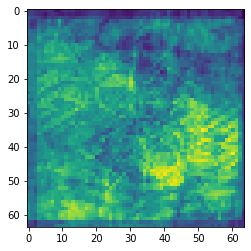

In [6]:
plt.imshow(np.array(train_set[100][0][0])+np.array(train_set[100][0][1])+np.array(train_set[100][0][2]))
print(train_set[100][1]) # Значение таргета картинки, хз что это за класс (животное какое-то)

### Вспомогательные функции, реализация модели

In [7]:
def SetRandomSeed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [8]:
class ConvNet(nn.Module): # seminars 2-3 193
    def __init__(self, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
        )
        
        self.head = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 200)
        )
        
    def forward(self, images):
        features = self.features(images)
        features = features.mean(dim=(2, 3))
        logits = self.head(features)
        return logits

In [19]:
class Coach(object):
    """
    Класс объекта тренера (коучер), который обучает модель нейросетки
    """
    def __init__(self, model, optimizer, criterion,
                 device, scheduler=None, n_epochs=2):
        
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.scheduler = scheduler
        
        self.init_epoch = 1
        self.n_epochs = n_epochs
        self.epoch = self.init_epoch
        
        self.best_accuracy = 0
        self.best_model = deepcopy(self.model)

        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        
    def run(self, train_loader, test_loader):
        
        for self.epoch in range(self.init_epoch, self.n_epochs + 1):
            
            self.__CalcPredict__(train_loader, train=True)
            self.__CalcPredict__(test_loader, train=False, save=False)
            
            if self.scheduler is not None:
                self.scheduler.step()
            
            self.plot()
    
    def plot(self):
        clear_output()
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
        self.__PlotAxes__(ax1, self.train_losses, self.test_losses, 'Losses')
        self.__PlotAxes__(ax2, self.train_accuracies, self.test_accuracies, 'Accuracy')
        plt.show()
    
    def reset(self):
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
    
    def __CalcPredict__(self, loader, train=False, save=True):
        
        name = 'Training' if train else 'Testing'
        true_labels = torch.Tensor().to(self.device)
        predicted = torch.Tensor().to(self.device)
        running_loss = 0.
        
        for data, labels in tqdm(loader, desc=name + f' {self.epoch}/{self.n_epochs}'):
            data = data.to(self.device)
            labels = labels.to(self.device)
            true_labels = torch.cat((labels, true_labels))

            outputs, loss = self.__TrainPredict__(data, labels) if train else self.__TestPredict__(data, labels)

            predicted = torch.cat((outputs, predicted))

            running_loss += loss.item() * data.shape[0]

        loss = running_loss / len(loader.dataset)
        predict_labels = torch.argmax(predicted, dim=1)
        
        if save:
            self.__CalcLoss__(loss, predict_labels, true_labels, train)

        return loss, predict_labels, true_labels
    
    def __TrainPredict__(self, data, labels):
        self.optimizer.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        return outputs, loss

    def __TestPredict__(self, data, labels):
        
        with torch.no_grad():
            outputs = self.model(data)
            loss = self.criterion(outputs, labels)  
            
        return outputs, loss
    
    def __CalcLoss__(self, loss, predicted_labels, true_labels, train=False):
        accuracy = accuracy_score(predicted_labels.cpu(), true_labels.cpu())
        
        if train:
            self.train_losses += [loss]
            self.train_accuracies += [accuracy]
            
        self.test_losses += [loss]
        self.test_accuracies += [accuracy]
        
        if self.test_accuracies[-1] > self.best_accuracy:
            self.best_model = deepcopy(self.model) 
            
    def __PlotAxes__(self, ax, train, test, name):
        ax.plot(range(1, self.epoch + 1), train, label='Train')
        ax.plot(range(1, self.epoch + 1), test, label='Test')
        ax.set_title(name + f' over epochs {self.epoch}')
        ax.set_ylabel(name)
        ax.set_xlabel('epoch')
        ax.legend()
        ax.grid()

### Обучение модели, запуски экспериментов

In [20]:
seed = SetRandomSeed(111)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss()
scheduler = None # torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
n_epochs = 2
Trainer = Coach(model, optimizer, criterion, device, n_epochs=n_epochs)

#### Проверка правильности написанного кода

In [21]:
all_losses, predicted_labels, true_labels = Trainer.__CalcPredict__(val_loader, save=False)
assert len(predicted_labels) == len(val_set)
accuracy = accuracy_score(predicted_labels.cpu(), true_labels.cpu())
print("tests passed")

Testing 1/2:   0%|          | 0/313 [00:00<?, ?it/s]

tests passed


In [ ]:
Trainer.run(train_loader, val_loader)

Training 1/2:   0%|          | 0/3125 [00:00<?, ?it/s]

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [ ]:
accuracy = 0.42
print(f'Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов,'\
      f' если вы делали часть 1, и {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов,'\
      f' если вы делали часть 2.')